In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image 
import time
from binary_feature_converter import Binary_feature_converter

from criterion import *


%matplotlib inline
img_folder = '../../../relazione/img/'


df_b = pd.DataFrame({
    'A': [0, 2, 3, 4, 1],
    'y_0': [0, 1, 1, 1, 0],
    'y_1': [1, 0, 0, 0, 0]}
)
df_b

A  y_0  y_1
0  0    0    1
1  2    1    0
2  3    1    0
3  4    1    0
4  1    0    0

In [4]:
bfc = Binary_feature_converter(pos_class=1,class_values=[100,-123],y_new_name='new_output',y_names=['y_0','y_1'])
bfc

class_values: [100, -123], pos_class: 1, y_names: ['y_0', 'y_1'], y_new_name: new_output

In [5]:
bfc.convert(df=df_b,target_variable='A')

A  new_output
0  0        -123
1  2        -123
2  3        -123
3  4        -123
4  1         100

## Criteri

Data una distribuzione $D$ abbiamo una variabile che assume solo due valori $a,b$. Indichiamo con $p(i)$ la probabilità in base a $D$ di osservare $i$. In base a questa probabilità è possibile determinare criteri la *quantità di informazione* o il *caos* tramite il calcolo dell'indice di Gini o di Entropia. Una stima di essi può essere fatta tramite la classification_error.

/home/lucavecchi/uni/metodi_stat_per_apprendimento/project/code/src/msa/criterion.py:17: RuntimeWarning: divide by zero encountered in log2
  return -(p * np.log2(p)).sum() if len(p)>0 else 0
/home/lucavecchi/uni/metodi_stat_per_apprendimento/project/code/src/msa/criterion.py:17: RuntimeWarning: invalid value encountered in multiply
  return -(p * np.log2(p)).sum() if len(p)>0 else 0


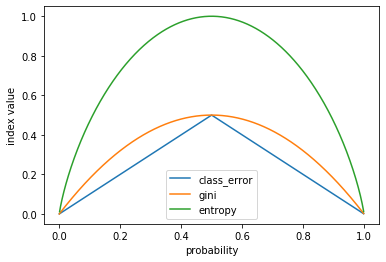

In [22]:
prob = np.array(range(0,1000,1))/1000
prob_a_b = [ np.array((1-el,el)) for el in prob ]
prob_x = [el[1] for el in prob_a_b]
y_class_error = [classification_error(p) for p in prob_a_b]
y_entropy = [entropy(p) for p in prob_a_b]
y_gini = [gini(p) for p in prob_a_b]


plt.plot(prob_x,y_class_error,label="class_error")
plt.plot(prob_x,y_gini,label="gini")
plt.plot(prob_x,y_entropy,label="entropy")
plt.legend()
plt.xlabel("probability")
plt.ylabel("index value")
plt.savefig(f'{img_folder}disorder_comparison.pdf')
plt.show()

Come si può vedere se la probabilità è perfettamente bilanciata ($p=0.5\quad \tilde{p}=0.5=1-p$) otteniamo il massimo di gini che si verifica nel caso di perfetta equità e il massimo dell'informazione per quanto riguarda l'entropia. Oppure si può vedere come la quantità di informazione richiesta per la descrizione dei dati.


### Performance

/home/lucavecchi/uni/metodi_stat_per_apprendimento/project/code/src/msa/criterion.py:17: RuntimeWarning: divide by zero encountered in log2
  return -(p * np.log2(p)).sum() if len(p)>0 else 0
/home/lucavecchi/uni/metodi_stat_per_apprendimento/project/code/src/msa/criterion.py:17: RuntimeWarning: invalid value encountered in multiply
  return -(p * np.log2(p)).sum() if len(p)>0 else 0


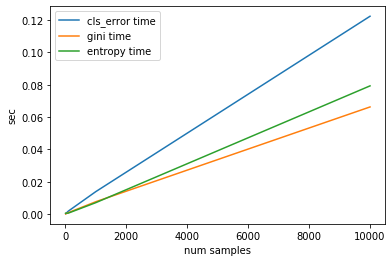

In [39]:
test_values = np.array([10**el for el in range(1,5)])
def test_bench(t_values,crit):
    prob = np.arange(0,t_values.max())/t_values.max()
    
    res = np.empty(t_values.shape[0],dtype=float)
    for nth, el in enumerate(t_values):
        start = time.time()
        [crit(np.array([prob[e],1-prob[e]])) for e in range(el)]
        res[nth] = time.time()- start
    return res
c_e_time = test_bench(test_values,lambda x: classification_error(x))
g_time = test_bench(test_values,lambda x: gini(x))
e_time = test_bench(test_values,lambda x: entropy(x))

plt.plot(test_values,c_e_time,label='cls_error time')
plt.plot(test_values,g_time,label='gini time')
plt.plot(test_values,e_time,label='entropy time')
plt.xlabel("num samples")
plt.ylabel("sec")
plt.legend()
plt.savefig(f'{img_folder}disorder_time_comparison.pdf')
plt.show()


### Conclusioni 
Dato il seguente grafico si può notare come il *classification error* presenti un tempo di calcolo maggiore rispetto al calcolo di gini e dell'entropia. 
Si può supporre che sia minore il tempo di calcolo di gini per via dell'assenza del logaritmo.

Questo però rappresenta solo il contenuto informativo di una distribuzione, non ci dice qual'è il migliore split.

Il fatto di conoscere l'evento che l'elemento $t$-esimo *sia* o *non sia* più alto di una soglia o che l'elemento $t$-esimo appartenga alla classe $A$ o $B$ o $C$ o piuttosto alla classe $B \cup C$ modifica sempre, a meno di casi degenere, la probabilità di osservare $i$. 
Come si modifica $p(i)$ conoscendo l'evento B?

Beh semplicemente $p(i) = p(i | A) + p(i | B) + ... + p(i | C)$ con $A,B,C$ elementi che partizionano lo spazio degli eventi.

Prendiamo per ipotesi solo regole che hanno come effetto quello di fare uno split binario (brutto). 

Sotto queste ipotesi allora data $H(i)= -p_ilg(p_i) - p_\tilde{i}log(p_\tilde{i})$ dobbiamo scegliere la partizione dello spazio degli eventi che ci permette di minimizzare l'entropia, cioè la quantità d'informazione necessaria o il caos per descrivere una certa distribuzione.
Quindi definiamo $s \in Splits$ dove $Split$ è lo spazio dei possibili split, siamo interessati a trovare:
$$ \hat{s}\quad =\quad \underset{s \in Splits}{arg min}\ H(i) - H(i | s )\quad =\quad \underset{s \in Splits}{arg min} - H(i | s )\quad =\quad \underset{s \in Splits}{arg min} - \frac{N_{\text{s vero}}}{N_{elementi}}H(i | s \text{ vero}) - \frac{N_{\text{s falso}}}{N_{elementi}}H(i | s \text{ falso})$$
Chiamiamo *information gain* $IG$ di $i$ dato $s$ la quantità $IG(i | s) \equiv H(i) - H(i | s )$; durante la selezione nell'$i$esimo round sceglieremo il nodo che ha information gain migliore.

## Entropia - Gini - Classification error *WEIGHTED*
Sappiamo che in Adaboost abbiamo una distribuzione degli elementi $i$ $D_t(i)$ al $t$-esimo round.
Inizialmente essa è costante:
$$ D_t(i):= \frac{1}{m} \quad \forall i \in \{1,...,|X|\}$$
e viene aggiornata ad ogni round come:
$$ D_{t+1}(i) = \frac{D_t(i)}{Z_t}e^{\pm\alpha_t} $$ 
in cui $Z_t$ è un fattore di normalizzazione e $\pm\alpha$ dipende se l'$i$-esimo elemento è stato classificato correttamente o no.


In particolare la distribuzione viene usata per calcolare l'errore atteso $\epsilon_{t+1}= P_{(x,y) \tilde D_t }[h_t(x) \not = y]$ ma soprattuto viene usata per la scelta dello stump.